In [1]:
#imports
import gzip
import pandas as pd
import os
from collections import defaultdict
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import ast
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
#define path
path = os.getcwd()
print(path)

c:\Users\fried\Desktop\Project_emerson


# Functions 

### 1. Match patients with TCRs
##### Read all the patient files and make a dictionary where key = combination, value = list of reperoire_ids

In [3]:
def read_patient_files(patients_path, number_of_patients=666, training=True):
    files_path = path + patients_path #'\\data\\HLA_emerson_2017'

    all_files = os.listdir(files_path)

    tsv_gz_files = [f for f in all_files if f.endswith('.tsv.gz')]

    if training == True:
        tsv_gz_files = tsv_gz_files[:number_of_patients] #tsv_gz_files[:400]

    elif training == False:
        tsv_gz_files = tsv_gz_files[number_of_patients:]

    patient_names = [f.split('.')[0] for f in tsv_gz_files]

    return tsv_gz_files, patient_names

In [4]:
def matching_patients_tcrs(patients_path, number_of_patients=400, top_n=None):
    tsv_gz_files, patient_names = read_patient_files(patients_path, number_of_patients)

    files_path = path + patients_path #'\\data\\HLA_emerson_2017'

    clonotype_occurences = defaultdict(set)

    for f in tsv_gz_files:
        file_path = os.path.join(files_path, f)
        with gzip.open(file_path, 'rt') as fi:
            # Inlezen als pandas DataFrame
            df = pd.read_csv(fi, sep='\t')
            # Select only top_n rows if top_n is not None and top_n is less than the number of rows
            if top_n is not None and top_n < len(df):
                df = df.head(top_n)

            for row in df.itertuples(index=False):
                combination = (row.v_call, row.junction_aa, row.j_call)
                rep_id = row.repertoire_id
                clonotype_occurences[combination].add(rep_id)


    tcr_df = pd.DataFrame(list(clonotype_occurences.items()), columns=['combination', 'repertoire_ids'])
    tcr_df = tcr_df[tcr_df['repertoire_ids'].apply(len) >= 5]
    tcr_df.reset_index(drop=True, inplace=True)
    return tcr_df



In [5]:
def write_to_file(data, filename):
    data.to_csv(filename, sep='\t', index=False)

In [6]:
def read_file(filename):
    return pd.read_csv(filename, sep='\t')

In [8]:
## execute the function
tcr_df = matching_patients_tcrs('\\data\\HLA_emerson_2017')


KeyboardInterrupt: 

In [9]:
#write_to_file(tcr_df, 'results\\tcr_df_output.tsv')
tcr_df = read_file('results\\tcr_df_output.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)

In [52]:
tcr_df.head()

,combination,repertoire_ids
0,"('TRBV7-9', 'CASSLARSTGELFF', 'TRBJ2-2')","{DenverT1D-315_TCRB, DenverT1D-274_TCRB, Daisy..."
1,"('TRBV7-9', 'CASSLEGTGGAAYGYTF', 'TRBJ1-2')","{Daisy-2_TCRB, DenverT1D-354_TCRB, DenverT1D-0..."
2,"('TRBV6-4', 'CASSGENTGELFF', 'TRBJ2-2')","{310221_TCRB, DenverT1D-274_TCRB, DenverT1D-04..."
3,"('TRBV28', 'CASSSDRVYGYTF', 'TRBJ1-2')","{DenverT1D-315_TCRB, 310159_TCRB, DenverT1D-25..."
4,"('TRBV6-4', 'CASSLTGTNSPLHF', 'TRBJ1-6')","{DenverT1D-095_TCRB, DenverT1D-184_TCRB, 31010..."


### 2. Match HLA-labelling of patients
##### Match the HLA-labelling with the patient files (A_02_01_features.txt contains the indices to the patient files)


In [7]:
def match_hla(patients_path, hla_path):
    tsv_gz_files, all_patient_names = read_patient_files(patients_path)

    record =  {}  # Temporary dictionary to hold one record
    file_path = path + hla_path #'\\data\\A_02_01_features.txt'

    # Read and parse the file
    with open(file_path, "r") as file:
        for line in file:
            line = line.split(" ")
            if line[1] == 'HLA-A*02:01':
                key = line[2]
                for i in range(5, len(line)):
                    value = line[i]
                    if value == '\n':
                        continue
                    ## value is the index to the patient file
                    patient = all_patient_names[int(value)]
                    if key in ['num_positives:']:
                        record[patient] = True
                    elif key in ['num_negatives:']:
                        record[patient] = False   


    for patient in all_patient_names:
        if patient not in record.keys():
            record[patient] = None

    patient_df = pd.DataFrame(list(record.items()), columns=['repertoire_id', 'has_HLA_A02_01'])
    patient_df.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)
    return patient_df
   
    

In [8]:
## select number of patients of the hla labelling for training or testing and remove rows with missing values
def select_patients_hla_labelling(patient_df, number_of_patients=666, hla_column='has_HLA_A02_01', training=True):
    if training == True:
        patient_df = patient_df.iloc[:number_of_patients]
    elif training == False:
        patient_df = patient_df.iloc[number_of_patients:]
    patient_df = patient_df[patient_df['has_HLA_A02_01'].notna()]
    patient_df.reset_index(drop=True, inplace=True)    
    return patient_df

In [53]:
patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df)

patient_df.head()

,repertoire_id,has_HLA_A02_01
0,P00001_clonotypes,False
1,P00002_clonotypes,True
2,P00003_clonotypes,True
3,P00004_clonotypes,True
4,P00005_clonotypes,False


### 3. Fisher-exact method
#####  Make a dataframe where every row contains the TCR (combination), the p-value and odds ratio of fisher_exact method (use psuedocount of 0.1)

In [10]:
def execute_fisher_exact(tcr_df, patient_df):
    fisher_exact_results = []
    for index, row in tcr_df.iterrows():
        # Haal de eerste rij van tcr_df en zijn combinatie en repertoire_ids
        repertoire_ids = row['repertoire_ids']  # Aangenomen dat repertoire_ids een lijst is
        combination = row['combination']

        # Filter patient_df op basis van de repertoire_ids
        filtered_patients = patient_df[patient_df['repertoire_id'].isin(repertoire_ids)]

        # Tel het aantal patiënten in elke categorie
        have_hla_and_tcr = len(filtered_patients[filtered_patients['has_HLA_A02_01'] == True]) + 0.1  # Aantal met HLA en TCR
        have_no_hla_and_tcr = len(filtered_patients[filtered_patients['has_HLA_A02_01'] == False]) + 0.1  # Aantal zonder HLA maar met TCR


        # Aantal patiënten zonder TCR
        have_hla_no_tcr = len(patient_df[(patient_df['has_HLA_A02_01'] == True) & 
                                                (~patient_df['repertoire_id'].isin(repertoire_ids))]) + 0.1
        have_no_hla_no_tcr = len(patient_df[(patient_df['has_HLA_A02_01'] == False) & 
                                                    (~patient_df['repertoire_id'].isin(repertoire_ids))]) + 0.1
        

        # Maak de 2x2-contingentietabel
        contingency_table = [
            [
                have_hla_and_tcr,  # a: patiënten met zowel HLA als TCR
                have_no_hla_and_tcr  # b: patiënten zonder HLA maar met TCR
            ],
            [
                have_hla_no_tcr,  # c: patiënten met HLA maar zonder TCR
                have_no_hla_no_tcr  # d: patiënten zonder HLA en zonder TCR
            ]
        ]


        # Voer de Fisher's Exact Test uit
        odds_ratio, p_value = fisher_exact(contingency_table)

        # Voeg de resultaten toe aan de lijst
        fisher_exact_results.append({
            'HLA': 'HLA-A*02:01',
            'TCR': combination,
            'odds_ratio': odds_ratio,
            'p_value': p_value,
            'have_hla_and_tcr' : have_hla_and_tcr,
            'have_no_hla_and_tcr': have_no_hla_and_tcr,
            'have_hla_no_tcr': have_hla_no_tcr,
            'have_no_hla_no_tcr': have_no_hla_no_tcr
        })

    # Zet de resultaten om in een DataFrame
    fisher_exact_results_df = pd.DataFrame(fisher_exact_results)

    # Neem de -log10 van de p-value en de log2 van de odds_ratio en voeg ze toe aan de DataFrame
    fisher_exact_results_df['log2_odds_ratio'] = np.log2(fisher_exact_results_df['odds_ratio'])
    fisher_exact_results_df['neg_log10_p_value'] = -np.log10(fisher_exact_results_df['p_value'])

    # Voeg een kolom toe om te controleren of de p-value kleiner is dan 0.05
    fisher_exact_results_df['significant'] = fisher_exact_results_df['p_value'] < 0.05

    return fisher_exact_results_df



In [11]:
def generate_volcano_plot(fisher_exact_results_df, filename):
    # Maak een Volcano Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=fisher_exact_results_df, 
                    x='log2_odds_ratio', 
                    y='neg_log10_p_value',
                    hue='significant')
    plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
    plt.xlabel('log2(Odds Ratio)')
    plt.ylabel('-log10(p-value)')
    plt.title('Volcano Plot')
    plt.savefig(filename)
    plt.show()

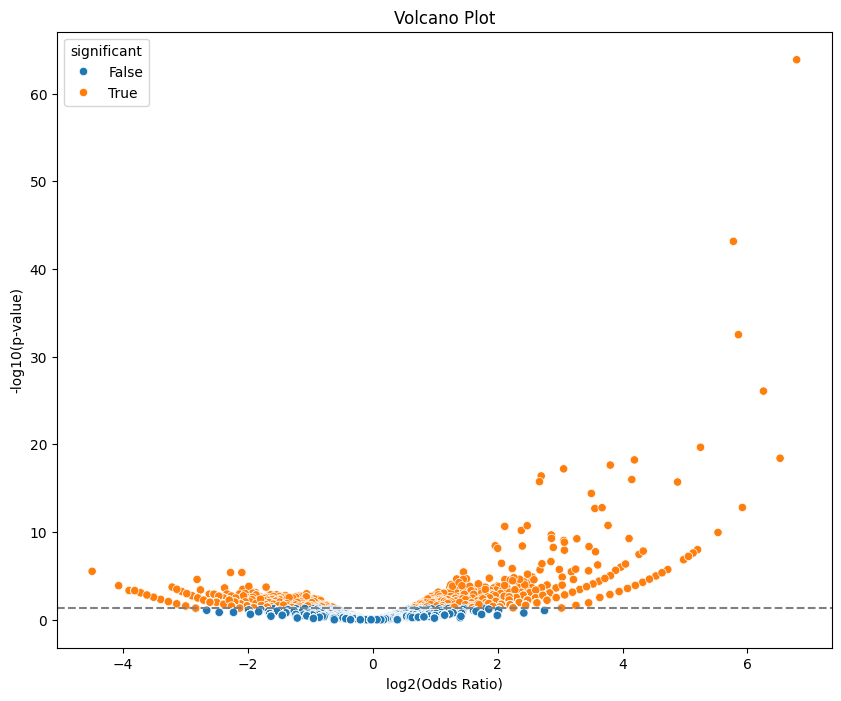

In [ ]:
patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df, 400)
fisher_exact_results_df = execute_fisher_exact(tcr_df, patient_df)
write_to_file(fisher_exact_results_df, 'results\\fisher_exact_results.tsv')

generate_volcano_plot(fisher_exact_results_df, 'results\\plots\\volcano_plot.png')

### 4. Train classifier model
#####  match/count the HLA-02.01 related TCR's for every patient
##### make a table with 3 columns: patient, #total TCR's and #HLA-02.01 related TCR's (from the fisher_exact_results_df where p-value < 0.05 and odds_ratio > 1)

In [12]:
def apply_benjamini_hochberg(fisher_exact_results_df):
    # Voer de Benjamini-Hochberg-correctie uit
    fisher_exact_results_df = fisher_exact_results_df.sort_values(by='p_value').reset_index(drop=True)
    fisher_exact_results_df['corrected_p_value'] = fisher_exact_results_df['p_value'] * len(fisher_exact_results_df) / (fisher_exact_results_df.index + 1)

    return fisher_exact_results_df

In [14]:
def match_and_select_related_tcrs(fisher_exact_results_df, hla_labelling, patients_path, 
                                  top_n=10, number_patients=666, sort_column='p_value', benjamini_hochberg=False, selected_tcrs_patients=None):
    
    tsv_gz_files, patient_names = read_patient_files(patients_path, number_patients)

    files_path = path + patients_path #'\\data\\HLA_emerson_2017'

    result_data = []
    related_tcrs = fisher_exact_results_df[(fisher_exact_results_df['p_value'] < 0.05) & (fisher_exact_results_df['odds_ratio'] > 1)].reset_index(drop=True)
    print("Related TCRs fisher exact: ",len(related_tcrs)) 
    top_related_tcrs = related_tcrs.sort_values(by=[sort_column]).head(top_n)

    if benjamini_hochberg:
        fisher_exact_results_df = apply_benjamini_hochberg(fisher_exact_results_df)
        related_tcrs = fisher_exact_results_df[(fisher_exact_results_df['corrected_p_value'] < 0.05) & (fisher_exact_results_df['odds_ratio'] > 1)].reset_index(drop=True)
        if sort_column == 'p_value':
            top_related_tcrs = related_tcrs.sort_values(by=['corrected_p_value']).head(top_n)
        else:
            top_related_tcrs = related_tcrs.sort_values(by=[sort_column]).head(top_n)

    print("Selected related TCRs: ",len(top_related_tcrs)) 

    
    for f in tsv_gz_files:
        file_path = os.path.join(files_path, f)
        with gzip.open(file_path, 'rt') as fi:
            # Inlezen als pandas DataFrame
            df = pd.read_csv(fi, sep='\t')
            
            # Controleer of DataFrame niet leeg is
            if df.empty:
                continue

            if selected_tcrs_patients is not None:
                df = df.head(selected_tcrs_patients)
                #print("Selected TCRs per patient: ",selected_tcrs_patients)
            
            # Voeg de TCR-combinaties toe als tuple
            if {'v_call', 'junction_aa', 'j_call'}.issubset(df.columns):
                df['TCR'] = [tuple(tcr) for tcr in zip(df['v_call'], df['junction_aa'], df['j_call'])]            
            else:
                continue  # Sla over als de vereiste kolommen ontbreken
            
            # Haal totalen op
            total_tcrs = len(df)
            rep_id = df['repertoire_id'].iloc[0]  # Gebruik .iloc om een fout te voorkomen

            # check if value of HLA-A*02:01 is NaN
            has_hla = None
            hla_row = hla_labelling[hla_labelling['repertoire_id'] == rep_id]
            if not hla_row.empty:
                has_hla = hla_row['has_HLA_A02_01'].iloc[0]
            #if hla is NaN value, change to None
            if pd.isna(has_hla):  # Controleer of de waarde NaN is
                has_hla = None
            
            # Zoek naar matches met de significante TCRs
            matching_tcrs = df[df['TCR'].isin(top_related_tcrs['TCR'])].shape[0]
            
            # Voeg de resultaten toe aan de lijst
            result_data.append({
                'repertoire_id': rep_id,
                'total_tcrs': total_tcrs,
                'related_tcrs': matching_tcrs,
                'has_HLA_A02_01': has_hla
            })

    # Als je de data als een DataFrame wilt hebben
    result_df = pd.DataFrame(result_data)

    if len(top_related_tcrs) < top_n:
        return result_df, len(top_related_tcrs)

    return result_df 

    

In [15]:
def calculate_metrics(result_df):
    # Compute the confusion matrix
    cm = confusion_matrix(result_df['has_HLA_A02_01_label'], result_df['prediction'])
    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics
    sensitivity = TP / (TP + FN)  # True Positive Rate
    specificity = TN / (TN + FP)  # True Negative Rate
    accuracy = (TP + TN) / (TP + TN + FP + FN)  # Overall accuracy

    # Print results
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    print(classification_report(result_df['has_HLA_A02_01_label'], result_df['prediction'], target_names=['Class 0', 'Class 1']))
    return sensitivity, specificity, accuracy

In [16]:
#make a ROC curve for the trained model
def plot_roc_curve(result_df, top_n, training=True, benjamini_hochberg=False, 
                   threshold=None, selected_tcrs_patients=None, semi_supervised=False):
    # Bereken ROC-curve en AUC
    fpr, tpr, thresholds = roc_curve(result_df['has_HLA_A02_01_label'], result_df['probability'])
    roc_auc = auc(fpr, tpr)

    # Plot instellingen
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Bepaal titel en bestandsnaam
    dataset_type = "training" if training else "validation"
    title = f"ROC Logistic Regression top {top_n} related tcrs ({dataset_type.capitalize()} set)"
    filename = f"results\\plots\\ROC_Logistic_Regression_top{top_n}_related_tcrs_{dataset_type}.png"

    if benjamini_hochberg:
        title += ", Benjamini-Hochberg"
        filename = filename.replace(".png", "_bh.png")
    if threshold is not None:
        title += f", Threshold = {threshold}"
        filename = filename.replace(".png", f"_threshold_{threshold}.png")
    if selected_tcrs_patients is not None:
        title += f", Selected TCRs Patients = {selected_tcrs_patients}"
        filename = filename.replace(".png", f"_selected_tcrs_patients_{selected_tcrs_patients}.png")
    if semi_supervised:
        title += ", Semi-supervised"
        filename = filename.replace(".png", "_semi_supervised.png")

    # Toon en sla de plot op
    print(title)
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.5)
    plt.savefig(filename)
    plt.show()

    return roc_auc

In [17]:
def make_classifier(result_df, top_n=10, benjamini_hochberg=False, filename=None):
    # make classifier logistic regression: 
    # - features are total_tcrs and related_tcrs
    # - target is has_HLA_A02_01 
    # - save the model

    model = LogisticRegression()
    X = result_df[['total_tcrs', 'related_tcrs']]
    y = result_df['has_HLA_A02_01_label']
    model.fit(X, y)
    
    result_df['probability'] = model.predict_proba(X)[:, 1]
    result_df['prediction'] = model.predict(X)


    #save the model
    if benjamini_hochberg and filename == None:
        dump(model, 'results\\models\\logistic_regression_top' + str(top_n) + '_related_tcrs_bh.joblib')
    elif benjamini_hochberg == False and filename == None:
        dump(model, 'results\\models\\logistic_regression_top' + str(top_n) + '_related_tcrs.joblib')

    else:
        dump(model, filename)

    return result_df, model



In [18]:
def plot_total_vs_significant_tcrs(result_df, top_n=10, training=True, threshold=None):
    # Zorg ervoor dat de kolom consistente typen heeft
    # Zet None om naar een string 'None'
    result_df['has_HLA_A02_01'] = result_df['has_HLA_A02_01'].map(
        {True: True, False: False, None: 'None'}
    )

    plt.figure(figsize=(8, 6))  # Stel de grootte van de plot in
    palette = {True: 'green', False: 'red', 'None': 'blue'}

    # Maak de scatterplot met juiste kleurtoewijzing
    sns.scatterplot(
        x=result_df['total_tcrs'], 
        y=result_df['related_tcrs'], 
        hue=result_df['has_HLA_A02_01'],  # Gebruik de aangepaste kolom voor 'hue'
        palette=palette  # Geef kleuren op via het palette
    )

    # Voeg labels en titel toe
    plt.xlabel('# Total TCRs')
    plt.ylabel('# Significant TCRs')
    plt.legend(title='Has HLA-A*02:01', loc='upper right')
    
    if training == True:
        if threshold != None:
            plt.title('Total vs Significant TCRs per Patient TCRs(Training set, Top ' + str(top_n) + ' TCRs, Threshold ' + str(threshold) + ')')
            plt.savefig('results\\plots\\Total vs Significant TCRs per Patient_TCRs(Training set, Top ' + str(top_n) + ' TCRs, Threshold ' + str(threshold) + ').png')
        else:
            plt.title('Total vs Significant TCRs per Patient TCRs(Training set, Top ' + str(top_n) + ' TCRs)')
            plt.savefig('results\\plots\\Total vs Significant TCRs per Patient_TCRs(Training set, Top ' + str(top_n) + ' TCRs)')
    else:
        if threshold != None:
            plt.title('Total vs Significant TCRs per Patient TCRs(Validation set, Top ' + str(top_n) + ' TCRs, Threshold ' + str(threshold) + ')')
            plt.savefig('results\\plots\\Total vs Significant TCRs per Patient_TCRs(Validation set, Top ' + str(top_n) + ' TCRs, Threshold ' + str(threshold) + ').png')
        else:
            plt.title('Total vs Significant TCRs per Patient TCRs(Validation set, Top ' + str(top_n) + ' TCRs)')
            plt.savefig('results\\plots\\Total vs Significant TCRs per Patient_TCRs(Validation set, Top ' + str(top_n) + ' TCRs)')
            
    # Toon de plot
    plt.show()

In [56]:

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df)

fisher_exact_results_df = read_file('results\\fisher_exact_results.tsv')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)

result_df = match_and_select_related_tcrs(fisher_exact_results_df, patient_df, '\\data\\HLA_emerson_2017', top_n=20000)



Related TCRs fisher exact:  21989
Selected related TCRs:  20000


In [57]:
result_df.head()

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01
0,P00001_clonotypes,80376,150,False
1,P00002_clonotypes,72026,524,True
2,P00003_clonotypes,125428,1075,True
3,P00004_clonotypes,147857,1141,True
4,P00005_clonotypes,76068,120,False


### 5. Select different top related TRCs, train the model and calculate metrics
##### Make a table with the different metrics (AUC, sensitivity, specificity, accuracy) and different top related TCRs
##### Apply Benjamini-Hochberg correction
##### Select top n related TCRs based on p-value

In [ ]:
top_n = [5, 10, 20, 30, 50, 90, 100, 500, 1000, 5000, 10000, 20000]


metrics_training_data = []
metrics_validation_data = []

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df)

fisher_exact_results_df = read_file('results\\fisher_exact_results.tsv')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)

BN = [False]

for bn in BN:
# Filter the top_n list dynamically
    if bn:
        top_n = [n for n in top_n if n <= 90]  # Use only smaller values for BH correction

    for n in top_n:
        #training set
        result_df = match_and_select_related_tcrs(fisher_exact_results_df, patient_df, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
        result_df_copy = result_df.copy()

        # Make a label for the target (has_HLA_A02_01), model can't handle boolean values
        # 0 = False, 1 = True
        result_df['has_HLA_A02_01'] = result_df['has_HLA_A02_01'].replace('None', np.nan)
        #drop none values
        result_df = result_df.dropna()
        result_df['has_HLA_A02_01_label'] = result_df['has_HLA_A02_01'].astype('category').cat.codes
        
        #select first 400 patients for training
        result_df.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)    
        result_df_training = result_df.iloc[:400]

        result_df_training, model = make_classifier(result_df_training, n, benjamini_hochberg=bn)

        # Make roc curve
        roc_auc = plot_roc_curve(result_df_training, n, benjamini_hochberg=bn)
        sensitivity, specificity, accuracy = calculate_metrics(result_df_training)

        metrics_training_data.append({
            'top_n': n, 
            'benjamini_hochberg': bn,
            'roc_auc': roc_auc, 
            'sensitivity': sensitivity, 
            'specificity': specificity, 
            'accuracy': accuracy
        }) 
        result_df_training_plot = result_df_copy.iloc[:400]
        plot_total_vs_significant_tcrs(result_df_training_plot, n)

        #validation set
        result_df_validation = result_df.iloc[400:]
        X_val = result_df_validation[['total_tcrs', 'related_tcrs']]
        y_val = result_df_validation['has_HLA_A02_01_label']
        result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
        result_df_validation['prediction'] = model.predict(X_val)
        roc_auc = plot_roc_curve(result_df_validation, n, False, benjamini_hochberg=bn)
        sensitivity, specificity, accuracy = calculate_metrics(result_df_validation)

        metrics_validation_data.append({
            'top_n': n, 
            'benjamini_hochberg': bn,
            'roc_auc': roc_auc, 
            'sensitivity': sensitivity, 
            'specificity': specificity, 
            'accuracy': accuracy
        })
        result_df_validation_plot = result_df_copy.iloc[400:]
        plot_total_vs_significant_tcrs(result_df_validation_plot, n, False)


metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

write_to_file(metrics_training_df, 'results\\metrics_classifiers_training.tsv')
write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation.tsv')

metrics_training_df
metrics_validation_df

In [58]:
metrics_validation_df = read_file('results\\metrics_classifiers_validation.tsv')
metrics_validation_df

,top_n,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,False,0.488017,0.000000,1.000000,0.580786
1,10,False,0.963503,0.937500,0.977444,0.960699
2,20,False,0.979558,0.927083,0.984962,0.960699
3,30,False,0.990523,0.937500,1.000000,0.973799
4,50,False,0.992716,0.947917,0.984962,0.969432
5,90,False,0.994674,0.947917,0.977444,0.965066
6,100,False,0.997024,0.958333,0.984962,0.973799
7,500,False,0.975956,0.864583,0.984962,0.934498
8,1000,False,0.972118,0.802083,0.992481,0.912664
9,5000,False,0.900454,0.770833,0.857143,0.820961


### 6. Semi-supervised learning
##### semi-supervised learning of self-training, een model wordt gebruikt om labels toe te kennen aan nieuwe data (pseudo-labeling), en deze worden vervolgens toegevoegd aan de trainingsdata voor een nieuwe iteratie van modeltraining.

In [63]:
tcr_df = matching_patients_tcrs('\\data\\HLA_Mitchell_Michels_2022')

In [ ]:
write_to_file(tcr_df, 'results\\tcr_df_output_Mitchell.tsv')

In [96]:

tcr_df = read_file('results\\tcr_df_output_Mitchell.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)
tcr_df.head()

,combination,repertoire_ids
0,"('TRBV7-9', 'CASSLARSTGELFF', 'TRBJ2-2')","{DenverT1D-258_TCRB, Daisy-20_TCRB, DenverT1D-..."
1,"('TRBV7-9', 'CASSLEGTGGAAYGYTF', 'TRBJ1-2')","{DenverT1D-354_TCRB, 310216_TCRB, Daisy-16_TCR..."
2,"('TRBV6-4', 'CASSGENTGELFF', 'TRBJ2-2')","{310126_TCRB, 310216_TCRB, 310221_TCRB, Denver..."
3,"('TRBV28', 'CASSSDRVYGYTF', 'TRBJ1-2')","{DenverT1D-253_TCRB, DenverT1D-243_TCRB, 31028..."
4,"('TRBV6-4', 'CASSLTGTNSPLHF', 'TRBJ1-6')","{DenverT1D-184_TCRB, DenverT1D-095_TCRB, 31021..."


In [19]:
def read_patients_hla_labelling(hla_path):
    # Read the patients TCR files and make table with related TCRs
    patient_allel_path = path +  hla_path #"\\data\\HLA_Mitchell_Michels_2022.tsv"

    # Lees het TSV-bestand in als DataFrame
    patient_df_mitchell = pd.read_csv(patient_allel_path, sep='\t')


    # Definieer de kolommen die gecontroleerd moeten worden op lege lijsten
    hla_columns = ['HLA-A']#, 'HLA-B', 'HLA-C', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1', 'HLA-DPB1']

    # Filter de DataFrame om alleen rijen te behouden waar niet alle HLA-kolommen '[]' bevatten
    patient_df_filtered = patient_df_mitchell[~patient_df_mitchell[hla_columns].apply(lambda row: all(val == '[]' for val in row), axis=1)]

    #Remove all rows where column 'HLA-A' is NaN
    patient_df_filtered = patient_df_filtered[patient_df_filtered['HLA-A'].notna()]

    # Reset de indexen
    patient_df_filtered.reset_index(drop=True, inplace=True)

    patient_df_filtered = patient_df_filtered[['patient_id', 'HLA-A']]
    patient_df_filtered.rename(columns={'patient_id': 'repertoire_id'}, inplace=True)

    patient_df_filtered['has_HLA_A02_01'] = patient_df_filtered['HLA-A'].apply(lambda x: 'A*02:01' in x if isinstance(x, str) else False)
    patient_df_filtered = patient_df_filtered[['repertoire_id', 'has_HLA_A02_01']] 
    return patient_df_filtered

In [119]:

patient_df_mitchel = read_patients_hla_labelling('\\data\\HLA_Mitchell_Michels_2022.tsv')
patient_df_mitchel

    


,repertoire_id,has_HLA_A02_01
0,310148_TCRB,False
1,310230_TCRB,False
2,310122_TCRB,True
3,310204_TCRB,True
4,310221_TCRB,False
...,...,...
211,310106_TCRB,False
212,310113_TCRB,True
213,310266_TCRB,True
214,310175_TCRB,False


In [103]:
fisher_exact_results_df = execute_fisher_exact(tcr_df, patient_df_mitchel)
write_to_file(fisher_exact_results_df, 'results\\fisher_exact_results_Mitchell.tsv')


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [107]:
fisher_exact_results_df_mitchel = read_file('results\\fisher_exact_results_Mitchell.tsv')
fisher_exact_results_df_mitchel['TCR'] = fisher_exact_results_df_mitchel['TCR'].apply(ast.literal_eval)

In [120]:
result_df_mitchel = match_and_select_related_tcrs(fisher_exact_results_df_mitchel, patient_df_mitchel, '\\data\\HLA_Mitchell_Michels_2022', 100, benjamini_hochberg=False)
len(result_df_mitchel)

359

In [121]:
result_df_mitchel

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01
0,310101_TCRB,12759,2,True
1,310102_TCRB,67451,0,False
2,310103_TCRB,59566,8,True
3,310104_TCRB,108101,15,True
4,310105_TCRB,146091,11,True
...,...,...,...,...
354,DenverT1D-382_TCRB,232607,8,None
355,DenverT1D-383_TCRB,30351,0,None
356,DenverT1D-384_TCRB,219423,12,None
357,DenverT1D-386_TCRB,188585,17,None


In [122]:
## Read a trained model (Benjamini-Hochberg correction and top 50 related TCRs)
model = load('results\\models\\logistic_regression_top100_related_tcrs.joblib')
X_val = result_df_mitchel[['total_tcrs', 'related_tcrs']]


result_df_mitchel['probability'] = model.predict_proba(X_val)[:, 1]
result_df_mitchel['prediction'] = model.predict(X_val)

In [123]:
result_df_mitchel.head(10)

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01,probability,prediction
0,310101_TCRB,12759,2,True,0.594227,1
1,310102_TCRB,67451,0,False,0.014477,0
2,310103_TCRB,59566,8,True,0.729968,1
3,310104_TCRB,108101,15,True,0.889885,1
4,310105_TCRB,146091,11,True,0.066112,0
5,310106_TCRB,109520,3,False,0.006170,0
6,310108_TCRB,137896,18,True,0.880398,1
7,310109_TCRB,129277,0,False,0.000307,0
8,310110_TCRB,52862,4,True,0.279489,0
9,310111_TCRB,150293,2,False,0.000268,0


In [124]:
#calculate average probability
average_probability = result_df_mitchel['probability'].mean()
average_probability

0.43647820476766774

In [125]:
#calculate median of probability of model
median_probability = result_df_mitchel['probability'].median()
median_probability

0.0770385297166013

In [126]:
train_result_df = result_df_mitchel[['repertoire_id', 'total_tcrs', 'related_tcrs','prediction']]
train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)
train_result_df

C:\Users\fried\AppData\Local\Temp\ipykernel_15252\3173823734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)


,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01_label
0,310101_TCRB,12759,2,1
1,310102_TCRB,67451,0,0
2,310103_TCRB,59566,8,1
3,310104_TCRB,108101,15,1
4,310105_TCRB,146091,11,0
...,...,...,...,...
354,DenverT1D-382_TCRB,232607,8,0
355,DenverT1D-383_TCRB,30351,0,0
356,DenverT1D-384_TCRB,219423,12,0
357,DenverT1D-386_TCRB,188585,17,0


ROC Logistic Regression top 100 related tcrs (Training set)


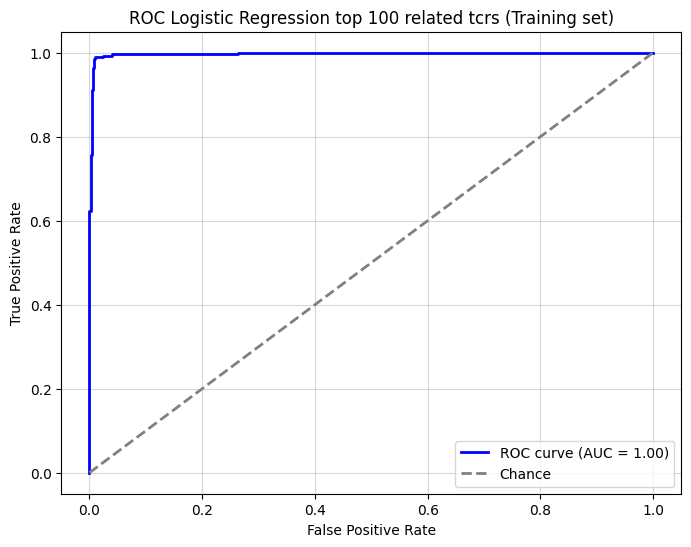

Sensitivity: 0.99
Specificity: 0.99
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       475
     Class 1       0.98      0.99      0.99       284

    accuracy                           0.99       759
   macro avg       0.99      0.99      0.99       759
weighted avg       0.99      0.99      0.99       759

ROC Logistic Regression top 100 related tcrs (Validation set)


C:\Users\fried\AppData\Local\Temp\ipykernel_15252\1054395001.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
C:\Users\fried\AppData\Local\Temp\ipykernel_15252\1054395001.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


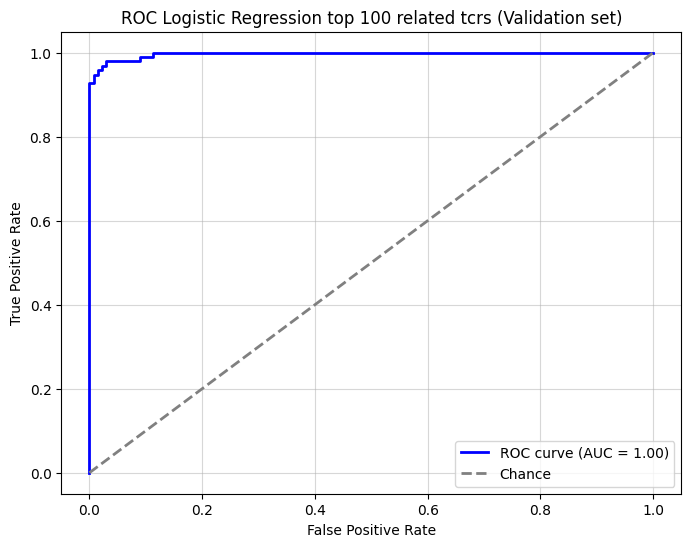

Sensitivity: 0.96
Specificity: 0.98
Accuracy: 0.97
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       133
     Class 1       0.98      0.96      0.97        96

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.97      0.97      0.97       229



,top_n,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,False,0.997024,0.958333,0.984962,0.973799


In [127]:
metrics_validation_data = []
metrics_training_data = []

bn = False
n = 100

patient_df_emerson = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_emerson = select_patients_hla_labelling(patient_df_emerson)

fisher_exact_results_df_emerson = read_file('results\\fisher_exact_results.tsv')
fisher_exact_results_df_emerson['TCR'] = fisher_exact_results_df_emerson['TCR'].apply(ast.literal_eval)

result_df_emerson = match_and_select_related_tcrs(fisher_exact_results_df_emerson, patient_df_emerson, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)



#training set
# 0 = False, 1 = True
result_df_emerson['has_HLA_A02_01'] = result_df_emerson['has_HLA_A02_01'].replace('None', np.nan)
#drop none values
result_df_emerson = result_df_emerson.dropna()
result_df_emerson['has_HLA_A02_01_label'] = result_df_emerson['has_HLA_A02_01'].astype('category').cat.codes

#select first 400 patients for training
result_df_emerson.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)    
result_df_training = result_df_emerson.iloc[:400]
result_df_training = pd.concat([train_result_df, result_df_training], ignore_index=True)

result_df_training, model = make_classifier(result_df_training, n, benjamini_hochberg=bn, filename='results\\models\\logistic_regression_semi_supervised_training.joblib')


# Make roc curve
roc_auc = plot_roc_curve(result_df_training, n, benjamini_hochberg=bn)
sensitivity, specificity, accuracy = calculate_metrics(result_df_training)

metrics_training_data.append({
    'top_n': n, 
    'benjamini_hochberg': bn,
    'roc_auc': roc_auc, 
    'sensitivity': sensitivity, 
    'specificity': specificity, 
    'accuracy': accuracy
}) 
#result_df_training_plot = result_df_copy.iloc[:400]
#plot_total_vs_significant_tcrs(result_df_training_plot, n)

#validation set
result_df_validation = result_df_emerson.iloc[400:]
X_val = result_df_validation[['total_tcrs', 'related_tcrs']]
y_val = result_df_validation['has_HLA_A02_01_label']
result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
result_df_validation['prediction'] = model.predict(X_val)
roc_auc = plot_roc_curve(result_df_validation, n, False, benjamini_hochberg=bn)
sensitivity, specificity, accuracy = calculate_metrics(result_df_validation)

metrics_validation_data.append({
    'top_n': n, 
    'benjamini_hochberg': bn,
    'roc_auc': roc_auc, 
    'sensitivity': sensitivity, 
    'specificity': specificity, 
    'accuracy': accuracy
})
#result_df_validation_plot = result_df_copy.iloc[400:]
#plot_total_vs_significant_tcrs(result_df_validation_plot, n, False)


metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

write_to_file(metrics_training_df, 'results\\metrics_classifiers_training_semi_supervised.tsv')
write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation_semi_supervised.tsv')

metrics_training_df
metrics_validation_df

In [128]:
print(len(result_df_validation))

229


### 7. Make the training data imbalanced
##### Lower the positive labels for HLA-A (from training data) to find a minimum threshold until where our trained model stays reliable


In [20]:
def select_positive_patients(patient_df, threshold='all'):
    """
    Reduceert het aantal positieve labels ('has_HLA_A02_01' == True) tot een bepaalde threshold.
    
    Parameters:
        patient_df (pd.DataFrame): DataFrame met patiënten, inclusief de kolom 'has_HLA_A02_01'.
        threshold (float): Proportie van positieve labels om te behouden (tussen 0 en 1).
        
    Returns:
        pd.DataFrame: Gereduceerde DataFrame met de gewenste proportie positieve labels.
    """

    if threshold == 'all': # Als er geen threshold is, geef de originele DataFrame terug
        return patient_df
    
    
    # Splits positieve en negatieve patiënten
    patient_df_positive = patient_df[patient_df['has_HLA_A02_01'] == True]
    patient_df_negative = patient_df[patient_df['has_HLA_A02_01'] == False]
    
    
    # Willekeurig een subset van de positieve patiënten selecteren op basis van de threshold, 
    # waarbij threshold het aantal patiënten is dat behouden moet worden (tussen 0 en totaal aantal positieve patiënten)
    reduced_positive_df = patient_df_positive.sample(n=min(threshold, len(patient_df_positive)), random_state=42)

    #reduced_positive_df = patient_df_positive.sample(frac=threshold, random_state=42)
    
    # Combineer de negatieve patiënten met de gereduceerde positieve patiënten
    result_df = pd.concat([reduced_positive_df, patient_df_negative], ignore_index=True)
    
    return result_df


In [19]:
tcr_df = read_file('results\\tcr_df_output.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)

In [34]:
thresholds = [5, 10, 15, 30, 50, 100, 'all']

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df, 400)

for threshold in thresholds:
    patients_df_filtered = select_positive_patients(patient_df, threshold)
    print("threshold = " + str(threshold))
    print(patients_df_filtered['has_HLA_A02_01'].value_counts())
    fisher_exact_results_df = execute_fisher_exact(tcr_df, patients_df_filtered)
    
    write_to_file(fisher_exact_results_df, 'results\\7\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')

threshold = 5
has_HLA_A02_01
False    211
True       5
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 10
has_HLA_A02_01
False    211
True      10
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 15
has_HLA_A02_01
False    211
True      15
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 30
has_HLA_A02_01
False    211
True      30
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 50
has_HLA_A02_01
False    211
True      50
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 100
has_HLA_A02_01
False    211
True     100
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = None
has_HLA_A02_01
False    211
True     161
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
thresholds = [5, 10, 15, 30, 50, 100]


metrics_training_data = []
metrics_validation_data = []

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
#patient_df= select_patients_hla_labelling(patient_df)

bn = False
n =  100

for threshold in thresholds:
    n =  100
    fisher_exact_results_df = read_file('results\\7\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')
    fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
    print("Fisher exact: ", len(fisher_exact_results_df))

    patient_df_training = select_patients_hla_labelling(patient_df, 400)
    patients_df_filtered = select_positive_patients(patient_df_training, threshold)

    #training set
    result_df_training = match_and_select_related_tcrs(fisher_exact_results_df, patients_df_filtered, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
    result_df_copy = result_df_training.copy()

    result_df_training = result_df_training.iloc[:400]
    print("Training set: ", len(result_df_training))
    print(result_df_training['has_HLA_A02_01'].value_counts())

    # Make a label for the target (has_HLA_A02_01), model can't handle boolean values
    # 0 = False, 1 = True
    result_df_training['has_HLA_A02_01'] = result_df_training['has_HLA_A02_01'].replace('None', np.nan)
    #drop none values
    result_df_training = result_df_training.dropna()
    result_df_training['has_HLA_A02_01_label'] = result_df_training['has_HLA_A02_01'].astype('category').cat.codes
    
    result_df_training.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)    
    print("Training set: ", len(result_df_training))
    

    filename = 'results\\7\\logistic_regression_top' + str(n) + '_related_tcrs_threshold_' + str(threshold) + '.joblib'
    result_df_training, model = make_classifier(result_df_training, n, benjamini_hochberg=bn, filename=filename)

    # Make roc curve
    roc_auc = plot_roc_curve(result_df_training, n, benjamini_hochberg=bn, threshold=threshold)
    sensitivity, specificity, accuracy = calculate_metrics(result_df_training)

    metrics_training_data.append({
        'top_n': n, 
        'threshold': threshold,
        'benjamini_hochberg': bn,
        'roc_auc': roc_auc, 
        'sensitivity': sensitivity, 
        'specificity': specificity, 
        'accuracy': accuracy
    }) 
    
    #plot_total_vs_significant_tcrs(result_df_training, top_n=n, threshold=threshold)

    #validation set
    n =  100
    patient_df_validation = select_patients_hla_labelling(patient_df, 400, training=False)
    result_df_validation = match_and_select_related_tcrs(fisher_exact_results_df, patient_df_validation, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
    
    # 0 = False, 1 = True
    result_df_validation['has_HLA_A02_01'] = result_df_validation['has_HLA_A02_01'].replace('None', np.nan)
    result_df_validation = result_df_validation.dropna()
    result_df_validation['has_HLA_A02_01_label'] = result_df_validation['has_HLA_A02_01'].astype('category').cat.codes
    result_df_validation.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)
    print("Validation set: ", len(result_df_validation))

    
    X_val = result_df_validation[['total_tcrs', 'related_tcrs']]
    y_val = result_df_validation['has_HLA_A02_01_label']
    result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
    result_df_validation['prediction'] = model.predict(X_val)
    roc_auc = plot_roc_curve(result_df_validation, n, False, benjamini_hochberg=bn, threshold=threshold)
    sensitivity, specificity, accuracy = calculate_metrics(result_df_validation)

    metrics_validation_data.append({
        'top_n': n, 
        'threshold': threshold,
        'benjamini_hochberg': bn,
        'roc_auc': roc_auc, 
        'sensitivity': sensitivity, 
        'specificity': specificity, 
        'accuracy': accuracy
    })
    #plot_total_vs_significant_tcrs(result_df_validation, top_n=n, training=False, threshold=threshold)
    
        

metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

write_to_file(metrics_training_df, 'results\\7\\metrics_classifiers_training_thresholds.tsv')
write_to_file(metrics_validation_df, 'results\\7\\metrics_classifiers_validation_thresholds.tsv')

metrics_training_df
metrics_validation_df

In [59]:
metrics_validation_df = read_file('results\\7\\metrics_classifiers_validation_thresholds.tsv')
metrics_validation_df

,top_n,threshold,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,5,False,0.611464,0.018692,1.000000,0.591440
1,100,10,False,0.774330,0.121495,1.000000,0.634241
2,100,15,False,0.887414,0.523364,0.993333,0.797665
3,100,30,False,0.962741,0.831776,1.000000,0.929961
4,100,50,False,0.981931,0.719626,1.000000,0.883268
5,100,100,False,0.991776,0.925234,0.993333,0.964981


#### 7.1. Select only top x TCRs in patient files
##### Run matching_patient_tcrs for a specific threshold of top TCRs
##### Execute fisher_exact method for these matching patient tcrs
##### Use the fisher_exact results for training and test data

In [ ]:
selected_tcrs_patients = [25000, 50000]
thresholds = [5, 10, 15, 30, 50, 100, 'all']

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df, 400)

for n in selected_tcrs_patients:
    tcr_df = matching_patients_tcrs('\\data\\HLA_emerson_2017', top_n=n)
    write_to_file(tcr_df, 'results\\7\\tcr_df_output_selected_' + str(n) + '_tcrs.tsv')

    for threshold in thresholds:
        patients_df_filtered = select_positive_patients(patient_df, threshold)
        print("threshold = " + str(threshold))
        print(patients_df_filtered['has_HLA_A02_01'].value_counts())
        fisher_exact_results_df = execute_fisher_exact(tcr_df, patients_df_filtered)
        
        write_to_file(fisher_exact_results_df, 'results\\7\\fisher_exact_results_threshold_' + str(threshold) + '_selected_' + str(n) + '_tcrs.tsv')

In [ ]:
thresholds = [5, 10, 15, 30, 50, 100, 'all']    
selected_tcrs_patients = [25000, 50000]

metrics_training_data = []
metrics_validation_data = []

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
#patient_df= select_patients_hla_labelling(patient_df)

bn = False
n =  100
for x in selected_tcrs_patients:
    for threshold in thresholds:
        fisher_exact_results_df = read_file('results\\7\\fisher_exact_results_threshold_' + str(threshold) + '_selected_' + str(x) + '_tcrs.tsv')
        fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
        print("Fisher exact: ", len(fisher_exact_results_df))

        patient_df_training = select_patients_hla_labelling(patient_df, 400)
        patients_df_filtered = select_positive_patients(patient_df_training, threshold)

        #training set
        result_df_training = match_and_select_related_tcrs(fisher_exact_results_df, patients_df_filtered, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
        result_df_copy = result_df_training.copy()

        result_df_training = result_df_training.iloc[:400]
        print("Training set: ", len(result_df_training))
        print(result_df_training['has_HLA_A02_01'].value_counts())

        # Make a label for the target (has_HLA_A02_01), model can't handle boolean values
        # 0 = False, 1 = True
        result_df_training['has_HLA_A02_01'] = result_df_training['has_HLA_A02_01'].replace('None', np.nan)
        #drop none values
        result_df_training = result_df_training.dropna()
        result_df_training['has_HLA_A02_01_label'] = result_df_training['has_HLA_A02_01'].astype('category').cat.codes

        result_df_training.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)    
        print("Training set: ", len(result_df_training))


        filename = 'results\\7\\logistic_regression_top' + str(n) + '_related_tcrs_threshold_' + str(threshold) + '_selected_' + str(x) + '.joblib'
        result_df_training, model = make_classifier(result_df_training, n, benjamini_hochberg=bn, filename=filename)

        # Make roc curve
        roc_auc = plot_roc_curve(result_df_training, n, benjamini_hochberg=bn, threshold=threshold, selected_tcrs_patients=x)
        sensitivity, specificity, accuracy = calculate_metrics(result_df_training)

        metrics_training_data.append({
            'top_n': n, 
            'threshold': threshold,
            'selected_tcrs_per_patient': x,
            'benjamini_hochberg': bn,
            'roc_auc': roc_auc, 
            'sensitivity': sensitivity, 
            'specificity': specificity, 
            'accuracy': accuracy
        }) 

        #plot_total_vs_significant_tcrs(result_df_training, top_n=n, threshold=threshold)

        #validation set
        patient_df_validation = select_patients_hla_labelling(patient_df, 400, training=False)
        result_df_validation = match_and_select_related_tcrs(fisher_exact_results_df, patient_df_validation, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)

        # 0 = False, 1 = True
        result_df_validation['has_HLA_A02_01'] = result_df_validation['has_HLA_A02_01'].replace('None', np.nan)
        result_df_validation = result_df_validation.dropna()
        result_df_validation['has_HLA_A02_01_label'] = result_df_validation['has_HLA_A02_01'].astype('category').cat.codes
        result_df_validation.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)
        print("Validation set: ", len(result_df_validation))


        X_val = result_df_validation[['total_tcrs', 'related_tcrs']]
        y_val = result_df_validation['has_HLA_A02_01_label']
        result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
        result_df_validation['prediction'] = model.predict(X_val)
        roc_auc = plot_roc_curve(result_df_validation, n, False, benjamini_hochberg=bn, threshold=threshold, selected_tcrs_patients=x)
        sensitivity, specificity, accuracy = calculate_metrics(result_df_validation)

        metrics_validation_data.append({
            'top_n': n, 
            'threshold': threshold,
            'selected_tcrs_per_patient': x,
            'benjamini_hochberg': bn,
            'roc_auc': roc_auc, 
            'sensitivity': sensitivity, 
            'specificity': specificity, 
            'accuracy': accuracy
        })
        #plot_total_vs_significant_tcrs(result_df_validation, top_n=n, training=False, threshold=threshold)

        

metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

write_to_file(metrics_training_df, 'results\\7\\metrics_classifiers_training_thresholds_selected_tcrs_.tsv')
write_to_file(metrics_validation_df, 'results\\7\\metrics_classifiers_validation_thresholds_selected_tcrs_.tsv')

metrics_training_df
metrics_validation_df

In [32]:
metrics_training_df

,top_n,threshold,selected_tcrs_per_patient,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,5,25000,False,1.000000,1.000000,1.000000,1.000000
1,100,10,25000,False,1.000000,1.000000,1.000000,1.000000
2,100,15,25000,False,1.000000,1.000000,1.000000,1.000000
3,100,30,25000,False,0.999368,0.966667,0.995261,0.991701
4,100,50,25000,False,0.999431,0.980000,0.995261,0.992337
5,100,100,25000,False,0.999384,0.990000,0.990521,0.990354
6,100,all,25000,False,0.998469,0.981366,0.981043,0.981183
7,100,5,50000,False,1.000000,1.000000,1.000000,1.000000
8,100,10,50000,False,1.000000,1.000000,0.995261,0.995475
9,100,15,50000,False,1.000000,1.000000,1.000000,1.000000


#### 7.2. Select only top x TCRs in patient files
##### Run matching_patient_tcrs for all TCRs in every patient
##### Execute fisher_exact method for these matching patient tcrs
##### Use the fisher_exact results for training data
##### For validation data, select only top x TCRs in patient files

In [ ]:
thresholds = [5, 10, 15, 30, 50, 100, 'all']
selected_tcrs_patients = [25000, 50000]

metrics_training_data = []
metrics_validation_data = []

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
#patient_df= select_patients_hla_labelling(patient_df)

bn = False
n =  100

for x in selected_tcrs_patients:
    for threshold in thresholds:
        n =  100
        fisher_exact_results_df = read_file('results\\7\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')
        fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
        print("Fisher exact: ", len(fisher_exact_results_df))

        patient_df_training = select_patients_hla_labelling(patient_df, 400)
        patients_df_filtered = select_positive_patients(patient_df_training, threshold)

        #training set
        result_df_training = match_and_select_related_tcrs(fisher_exact_results_df, patients_df_filtered, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
        result_df_copy = result_df_training.copy()

        result_df_training = result_df_training.iloc[:400]
        print("Training set: ", len(result_df_training))
        print(result_df_training['has_HLA_A02_01'].value_counts())

        # Make a label for the target (has_HLA_A02_01), model can't handle boolean values
        # 0 = False, 1 = True
        result_df_training['has_HLA_A02_01'] = result_df_training['has_HLA_A02_01'].replace('None', np.nan)
        #drop none values
        result_df_training = result_df_training.dropna()
        result_df_training['has_HLA_A02_01_label'] = result_df_training['has_HLA_A02_01'].astype('category').cat.codes
        
        result_df_training.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)    
        print("Training set: ", len(result_df_training))
        

        filename = 'results\\7\\logistic_regression_top' + str(n) + '_related_tcrs_threshold_' + str(threshold) + '.joblib'
        result_df_training, model = make_classifier(result_df_training, n, benjamini_hochberg=bn, filename=filename)

        # Make roc curve
        roc_auc = plot_roc_curve(result_df_training, n, benjamini_hochberg=bn, threshold=threshold)
        sensitivity, specificity, accuracy = calculate_metrics(result_df_training)

        metrics_training_data.append({
            'top_n': n, 
            'threshold': threshold,
            'selected_tcrs_per_patient': x,
            'benjamini_hochberg': bn,
            'roc_auc': roc_auc, 
            'sensitivity': sensitivity, 
            'specificity': specificity, 
            'accuracy': accuracy
        }) 
        
        #plot_total_vs_significant_tcrs(result_df_training, top_n=n, threshold=threshold)

        #validation set
        n =  100
        patient_df_validation = select_patients_hla_labelling(patient_df, 400, training=False)
        result_df_validation = match_and_select_related_tcrs(fisher_exact_results_df, patient_df_validation, 
                                                             '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn, selected_tcrs_patients=x)
        
        # 0 = False, 1 = True
        result_df_validation['has_HLA_A02_01'] = result_df_validation['has_HLA_A02_01'].replace('None', np.nan)
        result_df_validation = result_df_validation.dropna()
        result_df_validation['has_HLA_A02_01_label'] = result_df_validation['has_HLA_A02_01'].astype('category').cat.codes
        result_df_validation.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)
        print("Validation set: ", len(result_df_validation))

        
        X_val = result_df_validation[['total_tcrs', 'related_tcrs']]
        y_val = result_df_validation['has_HLA_A02_01_label']
        result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
        result_df_validation['prediction'] = model.predict(X_val)
        roc_auc = plot_roc_curve(result_df_validation, n, False, benjamini_hochberg=bn, threshold=threshold, selected_tcrs_patients=x)
        sensitivity, specificity, accuracy = calculate_metrics(result_df_validation)

        metrics_validation_data.append({
            'top_n': n, 
            'threshold': threshold,
            'selected_tcrs_per_patient': x,
            'benjamini_hochberg': bn,
            'roc_auc': roc_auc, 
            'sensitivity': sensitivity, 
            'specificity': specificity, 
            'accuracy': accuracy
        })
        #plot_total_vs_significant_tcrs(result_df_validation, top_n=n, training=False, threshold=threshold)
    
        

metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

write_to_file(metrics_training_df, 'results\\7\\metrics_classifiers_training_thresholds_selected_tcrs_validation.tsv')
write_to_file(metrics_validation_df, 'results\\7\\metrics_classifiers_validation_thresholds_selected_tcrs_validation.tsv')

metrics_training_df
metrics_validation_df

In [60]:
metrics_validation_df = read_file('results\\7\\metrics_classifiers_validation_thresholds_selected_tcrs_validation.tsv')
metrics_validation_df

,top_n,threshold,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,5,False,0.902243,0.177570,1.000000,0.657588
1,100,10,False,0.942617,0.532710,1.000000,0.805447
2,100,15,False,0.959688,0.766355,0.986667,0.894942
3,100,30,False,0.982960,0.934579,0.920000,0.926070
4,100,50,False,0.988349,0.672897,1.000000,0.863813
5,100,100,False,0.992586,0.971963,0.973333,0.972763
6,100,5,False,0.900436,0.046729,1.000000,0.603113
7,100,10,False,0.951433,0.355140,1.000000,0.731518
8,100,15,False,0.970000,0.728972,0.993333,0.883268
9,100,30,False,0.983084,0.915888,0.973333,0.949416


In [63]:
#add a column between top_n and threshold called 'selected_tcrs_per_patient'
# the first 5 rows contain the value 25000, the next 5 rows contain the value 50000
metrics_validation_df.insert(1, 'selected_tcrs_per_patient', [25000] * 6 + [50000] * 6)
metrics_validation_df

,top_n,selected_tcrs_per_patient,threshold,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,25000,5,False,0.902243,0.177570,1.000000,0.657588
1,100,25000,10,False,0.942617,0.532710,1.000000,0.805447
2,100,25000,15,False,0.959688,0.766355,0.986667,0.894942
3,100,25000,30,False,0.982960,0.934579,0.920000,0.926070
4,100,25000,50,False,0.988349,0.672897,1.000000,0.863813
5,100,25000,100,False,0.992586,0.971963,0.973333,0.972763
6,100,50000,5,False,0.900436,0.046729,1.000000,0.603113
7,100,50000,10,False,0.951433,0.355140,1.000000,0.731518
8,100,50000,15,False,0.970000,0.728972,0.993333,0.883268
9,100,50000,30,False,0.983084,0.915888,0.973333,0.949416


In [76]:
metrics_validation_df = read_file('results\\7\\metrics_classifiers_validation_thresholds_selected_tcrs_validation.tsv')
metrics_validation_df

,top_n,threshold,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,5,False,0.902243,0.177570,1.000000,0.657588
1,100,10,False,0.942617,0.532710,1.000000,0.805447
2,100,15,False,0.959688,0.766355,0.986667,0.894942
3,100,30,False,0.982960,0.934579,0.920000,0.926070
4,100,50,False,0.988349,0.672897,1.000000,0.863813
5,100,100,False,0.992586,0.971963,0.973333,0.972763
6,100,5,False,0.900436,0.046729,1.000000,0.603113
7,100,10,False,0.951433,0.355140,1.000000,0.731518
8,100,15,False,0.970000,0.728972,0.993333,0.883268
9,100,30,False,0.983084,0.915888,0.973333,0.949416


##### 7.3 Semi supervised learning with Mitchel data
##### Load one of the trained models on the Emerson data
##### Label the data of Mitchel using the loaded model
##### Use the labeled data of Mitchel together with the Emerson data to improve model

In [21]:
tcr_df = read_file('results\\tcr_df_output_Mitchell.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)
tcr_df.head()

,combination,repertoire_ids
0,"('TRBV7-9', 'CASSLARSTGELFF', 'TRBJ2-2')","{DenverT1D-315_TCRB, DenverT1D-274_TCRB, Daisy..."
1,"('TRBV7-9', 'CASSLEGTGGAAYGYTF', 'TRBJ1-2')","{Daisy-2_TCRB, DenverT1D-354_TCRB, DenverT1D-0..."
2,"('TRBV6-4', 'CASSGENTGELFF', 'TRBJ2-2')","{310221_TCRB, DenverT1D-274_TCRB, DenverT1D-04..."
3,"('TRBV28', 'CASSSDRVYGYTF', 'TRBJ1-2')","{DenverT1D-315_TCRB, 310159_TCRB, DenverT1D-25..."
4,"('TRBV6-4', 'CASSLTGTNSPLHF', 'TRBJ1-6')","{DenverT1D-095_TCRB, DenverT1D-184_TCRB, 31010..."


In [22]:
patient_df_mitchel = read_patients_hla_labelling('\\data\\HLA_Mitchell_Michels_2022.tsv')
patient_df_mitchel

,repertoire_id,has_HLA_A02_01
0,310148_TCRB,False
1,310230_TCRB,False
2,310122_TCRB,True
3,310204_TCRB,True
4,310221_TCRB,False
...,...,...
211,310106_TCRB,False
212,310113_TCRB,True
213,310266_TCRB,True
214,310175_TCRB,False


In [23]:
fisher_exact_results_df_mitchel = read_file('results\\fisher_exact_results_Mitchell.tsv')
fisher_exact_results_df_mitchel['TCR'] = fisher_exact_results_df_mitchel['TCR'].apply(ast.literal_eval)

In [55]:
fisher_exact_results_df_mitchel.head()

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant
0,HLA-A*02:01,"(TRBV7-9, CASSLARSTGELFF, TRBJ2-2)",2.018868,1.000000,2.1,1.1,106.1,107.1,1.013547,-0.000000,False
1,HLA-A*02:01,"(TRBV7-9, CASSLEGTGGAAYGYTF, TRBJ1-2)",inf,0.014134,7.1,0.1,101.1,108.1,inf,1.849720,True
2,HLA-A*02:01,"(TRBV6-4, CASSGENTGELFF, TRBJ2-2)",1.514286,1.000000,3.1,2.1,105.1,106.1,0.598637,-0.000000,False
3,HLA-A*02:01,"(TRBV28, CASSSDRVYGYTF, TRBJ1-2)",0.792308,1.000000,4.1,5.1,104.1,103.1,-0.335867,-0.000000,False
4,HLA-A*02:01,"(TRBV6-4, CASSLTGTNSPLHF, TRBJ1-6)",inf,0.246512,3.1,0.1,105.1,108.1,inf,0.608163,False


In [24]:
result_df_mitchel = match_and_select_related_tcrs(fisher_exact_results_df_mitchel, patient_df_mitchel, '\\data\\HLA_Mitchell_Michels_2022', top_n=100, benjamini_hochberg=False)
len(result_df_mitchel)

Related TCRs fisher exact:  2230
Selected related TCRs:  100


359

In [25]:
result_df_mitchel

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01
0,310101_TCRB,12759,2,True
1,310102_TCRB,67451,0,False
2,310103_TCRB,59566,8,True
3,310104_TCRB,108101,15,True
4,310105_TCRB,146091,11,True
...,...,...,...,...
354,DenverT1D-382_TCRB,232607,8,None
355,DenverT1D-383_TCRB,30351,0,None
356,DenverT1D-384_TCRB,219423,12,None
357,DenverT1D-386_TCRB,188585,17,None


In [26]:
## Read a trained model (Benjamini-Hochberg correction and top 50 related TCRs)
model = load('results\\7\\logistic_regression_top100_related_tcrs_threshold_15.joblib')
X_val = result_df_mitchel[['total_tcrs', 'related_tcrs']]


result_df_mitchel['probability'] = model.predict_proba(X_val)[:, 1]
result_df_mitchel['probability'] = result_df_mitchel['probability'].apply(lambda x: round(x, 2))
result_df_mitchel['prediction'] = model.predict(X_val)

In [32]:
result_df_mitchel.head(20)

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01,probability,prediction
0,310101_TCRB,12759,2,True,0.56,1
1,310102_TCRB,67451,0,False,0.00,0
2,310103_TCRB,59566,8,True,0.48,0
3,310104_TCRB,108101,15,True,0.57,1
4,310105_TCRB,146091,11,True,0.00,0
5,310106_TCRB,109520,3,False,0.00,0
6,310108_TCRB,137896,18,True,0.34,0
7,310109_TCRB,129277,0,False,0.00,0
8,310110_TCRB,52862,4,True,0.05,0
9,310111_TCRB,150293,2,False,0.00,0


In [50]:
def plot_box_plot(result_df, top_n, training=True):
    """
    Maakt een boxplot van de voorspelde kansen van de patiënten.
    
    Parameters:
        result_df (pd.DataFrame): DataFrame met de patiënten en hun voorspelde kansen.
        top_n (int): Aantal TCRs waarop de modellen getraind zijn.
        training (bool): Of de patiënten uit de training- of validatieset komen.
        threshold (int): De threshold die gebruikt is om de patiënten te selecteren.
    """
    
    # Maak een nieuwe figuur
    plt.figure(figsize=(10, 6))
    
    # Maak een boxplot van de voorspelde kansen
    sns.boxplot(
        x='has_HLA_A02_01',  # Gebruik de kolom 'has_HLA_A02_01' voor de x-as
        y='probability',  # Gebruik de kolom 'probability' voor de y-as
        data=result_df,  # Gebruik de DataFrame met de data
        palette='Set2'  # Gebruik een kleurenpalet
    )
    
    # Voeg labels en titel toe
    plt.xlabel('Has HLA-A*02:01')
    plt.ylabel('Predicted Probability')
    
    if training == True:
            plt.title('Predicted Probability per Patient (Training set, Top ' + str(top_n) + ' TCRs, Mitchel data)')
            #plt.savefig('results\\7\\plots\\Predicted Probability per Patient (Training set, Top ' + str(top_n) + ' TCRs)')
    else:
            plt.title('Predicted Probability per Patient (Validation set, Top ' + str(top_n) + ' TCRs, Mitchel data)')
            #plt.savefig('results\\7\\plots\\Predicted Probability per Patient (Validation set, Top ' + str(top_n) + ' TCRs)')




C:\Users\fried\AppData\Local\Temp\ipykernel_19580\3732432039.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


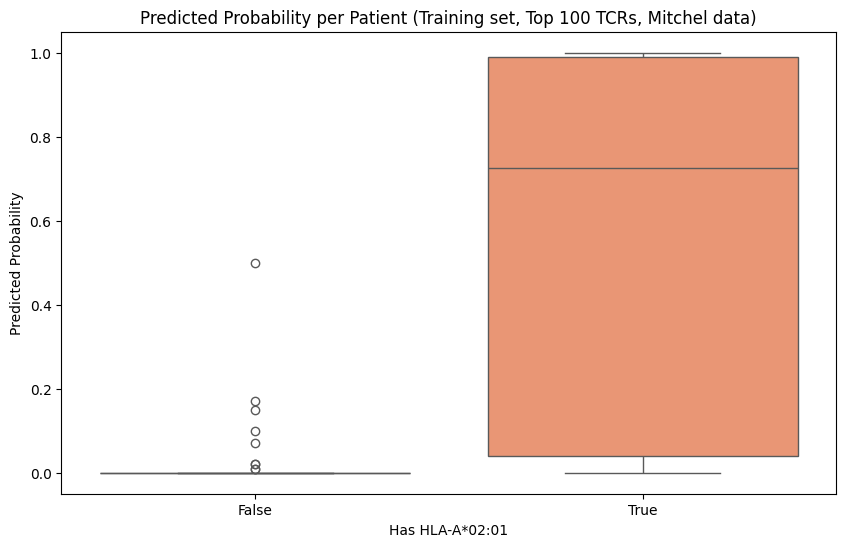

In [51]:
plot_box_plot(result_df_mitchel, 100)

In [34]:
result_df_mitchel['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
True     108
False    108
Name: count, dtype: int64

In [28]:
result_df_mitchel['prediction'].value_counts()

prediction
0    279
1     80
Name: count, dtype: int64

In [119]:
#calculate average probability
average_probability = result_df_mitchel['probability'].mean()
average_probability

0.22986072423398332

In [120]:
#calculate median of probability of model
median_probability = result_df_mitchel['probability'].median()
median_probability

0.0

In [33]:
#calculate accuracy, sensitivity and specificity
# True labels are 'has_HLA_A02_01', predicted label is 'prediction'
result_df_mitchel['has_HLA_A02_01'] =result_df_mitchel['has_HLA_A02_01'].replace('None', np.nan)

#drop none values
result_df_mitchel = result_df_mitchel.dropna()
result_df_mitchel['has_HLA_A02_01_label'] = result_df_mitchel['has_HLA_A02_01'].astype('category').cat.codes

calculate_metrics(result_df_mitchel)



Sensitivity: 0.58
Specificity: 1.00
Accuracy: 0.79
              precision    recall  f1-score   support

     Class 0       0.71      1.00      0.83       108
     Class 1       1.00      0.58      0.74       108

    accuracy                           0.79       216
   macro avg       0.85      0.79      0.78       216
weighted avg       0.85      0.79      0.78       216



C:\Users\fried\AppData\Local\Temp\ipykernel_19580\3998114544.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_mitchel['has_HLA_A02_01_label'] = result_df_mitchel['has_HLA_A02_01'].astype('category').cat.codes


(0.5833333333333334, 1.0, 0.7916666666666666)

In [122]:
result_df_mitchel['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
True     108
False    108
Name: count, dtype: int64

In [123]:
#count how many positive labels have a probability of 0.8 or higher
result_df_mitchel[result_df_mitchel['probability'] >= 0.8]['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
True    50
Name: count, dtype: int64

In [124]:
#count how many negative labels have a probability of 0.2 or lower
result_df_mitchel[result_df_mitchel['probability'] <= 0.15]['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
False    106
True      34
Name: count, dtype: int64

In [125]:
# Select only rows where prediction of positive (True) label is 0.8 or higher 
result_df_mitchel_filtered = result_df_mitchel[(result_df_mitchel['probability'] >= 0.8)]

In [126]:
result_df_mitchel_filtered['prediction'].value_counts()

prediction
1    50
Name: count, dtype: int64

In [99]:
train_result_df = result_df_mitchel_filtered[['repertoire_id', 'total_tcrs', 'related_tcrs','prediction']]
train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)


C:\Users\fried\AppData\Local\Temp\ipykernel_27560\532396224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)


Related TCRs fisher exact:  21222
Selected related TCRs:  100
Training set:  376
has_HLA_A02_01_label
0    361
1     15
Name: count, dtype: int64
Training set:  426
has_HLA_A02_01_label
0    361
1     65
Name: count, dtype: int64
ROC Logistic Regression top 100 related tcrs (Training set), Threshold = 15, Selected TCRs Patients = 25000, Semi-supervised


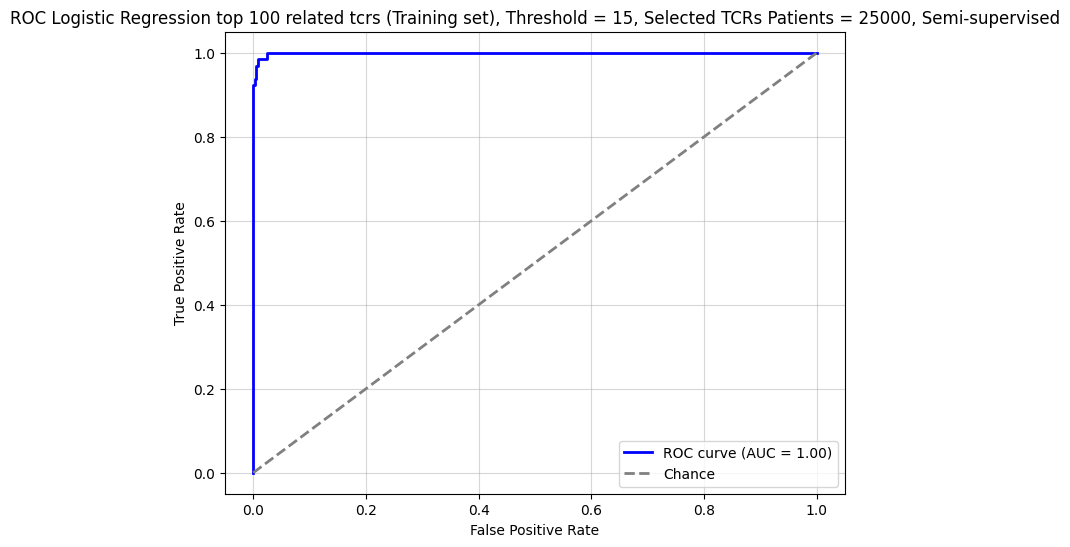

Sensitivity: 0.95
Specificity: 0.99
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       361
     Class 1       0.97      0.95      0.96        65

    accuracy                           0.99       426
   macro avg       0.98      0.97      0.98       426
weighted avg       0.99      0.99      0.99       426

Related TCRs fisher exact:  21222
Selected related TCRs:  100
Validation set:  257
ROC Logistic Regression top 100 related tcrs (Validation set), Threshold = 15, Selected TCRs Patients = 25000, Semi-supervised


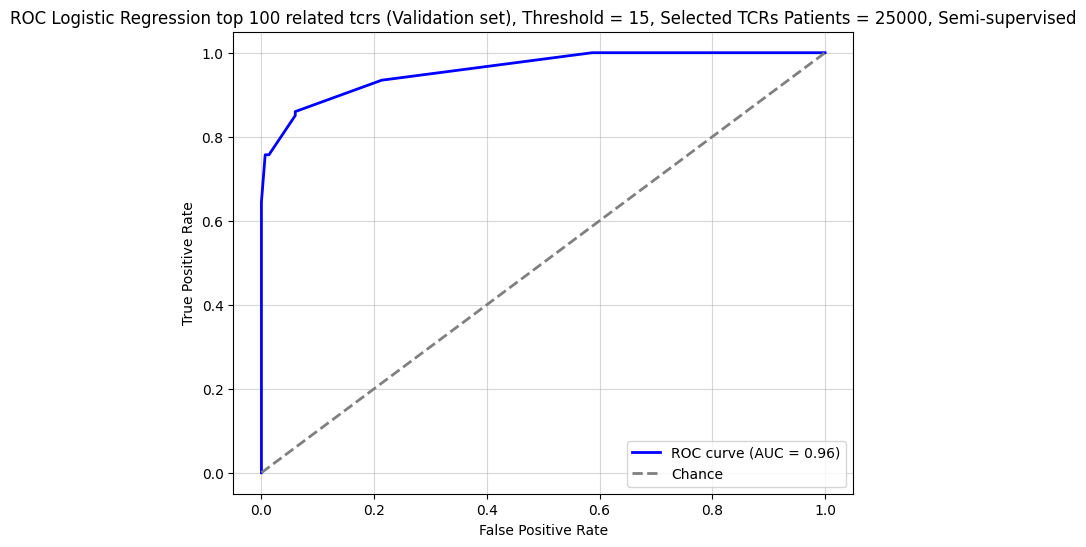

Sensitivity: 0.86
Specificity: 0.94
Accuracy: 0.91
              precision    recall  f1-score   support

     Class 0       0.90      0.94      0.92       150
     Class 1       0.91      0.86      0.88       107

    accuracy                           0.91       257
   macro avg       0.91      0.90      0.90       257
weighted avg       0.91      0.91      0.91       257



,top_n,threshold,selected_tcrs_per_patient,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,15,25000,False,0.959252,0.859813,0.94,0.906615


In [100]:
metrics_validation_data = []
metrics_training_data = []

bn = False
n = 100
threshold = 15
x = 25000

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_emerson = select_patients_hla_labelling(patient_df)
patient_df_emerson = select_positive_patients(patient_df_emerson, threshold)


fisher_exact_results_df_emerson = read_file('results\\7\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')
fisher_exact_results_df_emerson['TCR'] = fisher_exact_results_df_emerson['TCR'].apply(ast.literal_eval)

result_df_emerson = match_and_select_related_tcrs(fisher_exact_results_df_emerson, patient_df_emerson, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)



#training set
# 0 = False, 1 = True
result_df_emerson['has_HLA_A02_01'] = result_df_emerson['has_HLA_A02_01'].replace('None', np.nan)
#drop none values
result_df_emerson = result_df_emerson.dropna()
result_df_emerson['has_HLA_A02_01_label'] = result_df_emerson['has_HLA_A02_01'].astype('category').cat.codes

#select first 400 patients for training
result_df_emerson.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)    
result_df_training = result_df_emerson.iloc[:400]
print("Training set: ", len(result_df_training))
print(result_df_training['has_HLA_A02_01_label'].value_counts())
result_df_training = pd.concat([train_result_df, result_df_training], ignore_index=True)
print("Training set: ", len(result_df_training))
print(result_df_training['has_HLA_A02_01_label'].value_counts())

result_df_training, model = make_classifier(result_df_training, n, benjamini_hochberg=bn, filename='results\\models\\logistic_regression_semi_supervised_training_selected_tcrs.joblib')


# Make roc curve
roc_auc = plot_roc_curve(result_df_training, n, benjamini_hochberg=bn, threshold=threshold, selected_tcrs_patients=x, semi_supervised=True)
sensitivity, specificity, accuracy = calculate_metrics(result_df_training)

metrics_training_data.append({
    'top_n': n, 
    'threshold': threshold,
    'selected_tcrs_per_patient': x,
    'benjamini_hochberg': bn,
    'roc_auc': roc_auc, 
    'sensitivity': sensitivity, 
    'specificity': specificity, 
    'accuracy': accuracy
}) 
#result_df_training_plot = result_df_copy.iloc[:400]
#plot_total_vs_significant_tcrs(result_df_training_plot, n)

#validation set
patient_df_validation = select_patients_hla_labelling(patient_df, 400, training=False)
result_df_validation = match_and_select_related_tcrs(fisher_exact_results_df_emerson, patient_df_validation, 
                                                        '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn, selected_tcrs_patients=x)

# 0 = False, 1 = True
result_df_validation['has_HLA_A02_01'] = result_df_validation['has_HLA_A02_01'].replace('None', np.nan)
result_df_validation = result_df_validation.dropna()
result_df_validation['has_HLA_A02_01_label'] = result_df_validation['has_HLA_A02_01'].astype('category').cat.codes
result_df_validation.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)
print("Validation set: ", len(result_df_validation))

X_val = result_df_validation[['total_tcrs', 'related_tcrs']]
y_val = result_df_validation['has_HLA_A02_01_label']
result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
result_df_validation['prediction'] = model.predict(X_val)
roc_auc = plot_roc_curve(result_df_validation, n, False, benjamini_hochberg=bn, threshold=threshold, selected_tcrs_patients=x, semi_supervised=True)    
sensitivity, specificity, accuracy = calculate_metrics(result_df_validation)

metrics_validation_data.append({
    'top_n': n, 
    'threshold': threshold,
    'selected_tcrs_per_patient': x,
    'benjamini_hochberg': bn,
    'roc_auc': roc_auc, 
    'sensitivity': sensitivity, 
    'specificity': specificity, 
    'accuracy': accuracy
})


metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

write_to_file(metrics_training_df, 'results\\metrics_classifiers_training_semi_supervised_selected_tcrs.tsv')
write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation_semi_supervised.tsv_selected_tcrs')

metrics_training_df
metrics_validation_df